# Сравнение моделей

### Импорты

In [1]:
import pandas as pd
import numpy as np
import warnings
from typing import Dict, Any, Tuple, List

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    classification_report,
    roc_auc_score,
    accuracy_score,
    make_scorer,
    precision_score,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### Константы и Наборы Признаков

In [2]:
FEATURE_SETS: Dict[str, List[str]] = {
    "Standard (7)": [
        'rr_interval', 'P_interval', 'QRS_interval', 'QTc',
        'p_axis', 'qrs_axis', 't_axis'
    ],
    "Advanced_Full (14)": [
        'T_axis', 'QRS_interval', 'STT_RR_Ratio', 'QTc_Squared', 'ST_T_interval',
        'QRS_RR_Ratio', 'QRS_axis', 'P_QRS_Axis_Diff_cos', 'P_QRS_Axis_Diff_sin',
        'QRS_T_Axis_Diff', 'T_axis_cos', 'QRS_T_Axis_Diff_sin', 'P_interval', 'PR_interval'
    ],
    "Advanced_V1 (13)": [
        'T_axis', 'QRS_interval', 'STT_RR_Ratio', 'QTc_Squared', 'ST_T_interval',
        'QRS_RR_Ratio', 'QRS_axis', 'P_QRS_Axis_Diff_cos',
        'QRS_T_Axis_Diff', 'T_axis_cos', 'QRS_T_Axis_Diff_sin', 'P_interval', 'PR_interval'
    ],
    "Advanced_V2 (11)": [
        'T_axis', 'QRS_interval', 'STT_RR_Ratio', 'QTc_Squared', 'ST_T_interval',
        'QRS_RR_Ratio', 'QRS_axis', 'QRS_T_Axis_Diff', 'QRS_T_Axis_Diff_sin', 'P_interval', 'PR_interval'
    ],
    "Advanced_V3 (11)": [
        'T_axis', 'QRS_interval', 'STT_RR_Ratio', 'QTc_Squared', 'ST_T_interval',
        'PR_RR_Ratio', 'QRS_axis', 'QRS_T_Axis_Diff', 'QRS_T_Axis_Diff_sin', 'P_interval', 'PR_interval'
    ],
    "Advanced_V4 (9)": [
        'T_axis', 'QRS_interval', 'STT_RR_Ratio', 'QTc_Squared', 'ST_T_interval',
        'QRS_T_Axis_Diff', 'QRS_T_Axis_Diff_sin', 'QRS_axis_cos', 'PR_interval'
    ]
}

REFERENCE_RANGES: Dict[str, Tuple[int, int]] = {
        'P_interval': (60, 120),
        'PR_interval': (120, 200),
        'QRS_interval': (60, 110),
        'QT_interval': (350, 450)
    }

MAGIC_NUMBERS: List[int] = [29999, 32767]

RAW_FEATURE_COLS: List[str] = [
    'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end',
    'p_axis', 'qrs_axis', 't_axis', 'rr_interval'
]

### Подготовка признаков

In [3]:
class EcgFeatureTransformer(BaseEstimator, TransformerMixin):
    """
    Универсальный трансформер для полной обработки данных, от очистки до
    генерации и выбора финального набора признаков.
    """

    def __init__(
        self,
        final_features: List[str],
        std_threshold: float = 5.0,
        reference_ranges: Dict[str, Tuple[int, int]] = None,
        magic_numbers: List[int] = None,
        raw_feature_cols: List[str] = None,
    ):
        self.final_features = final_features
        self.std_threshold = std_threshold
        self.reference_ranges = reference_ranges or {
            'P_interval': (60, 120),
            'PR_interval': (120, 200),
            'QRS_interval': (60, 110),
            'QT_interval': (350, 450)
        }
        self.magic_numbers = magic_numbers or [29999, 32767]
        self.raw_feature_cols = raw_feature_cols or [
            'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end',
            'p_axis', 'qrs_axis', 't_axis', 'rr_interval'
        ]
        self.stats_ = {}

    def _angle_to_sin_cos(self, angle_deg: pd.Series) -> Tuple[pd.Series, pd.Series]:
        """Преобразует углы в градусах в синусную и косинусную компоненты."""
        rad = np.radians(angle_deg)
        return np.sin(rad), np.cos(rad)

    def _cyclical_angle_difference(
        self, angle1_deg: pd.Series, angle2_deg: pd.Series
    ) -> pd.Series:
        """Корректно вычисляет кратчайшую разницу между двумя углами."""
        diff = np.abs(angle1_deg - angle2_deg)
        return np.where(diff > 180, 360 - diff, diff)
    
    def fit(self, X: pd.DataFrame, y: None = None):
        """Собирает все необходимые статистики на обучающих данных."""
        df_clean = X.copy().replace(self.magic_numbers, np.nan)
        self.stats_ = {
            "medians": {},
            "mads": {},
            "derived_medians": {},
            "ref_defaults": {k: np.mean(v) for k, v in self.reference_ranges.items()},
            "winsor_limits": {},
        }
        for col in df_clean.columns:
            if pd.api.types.is_numeric_dtype(df_clean[col]):
                x_series = df_clean[col].dropna()
                if not x_series.empty:
                    self.stats_["medians"][col] = x_series.median()
                    self.stats_["mads"][col] = np.median(np.abs(x_series - x_series.median()))
        temp_df = df_clean.copy()
        temp_df["P_interval"] = temp_df["p_end"] - temp_df["p_onset"]
        temp_df["PR_interval"] = temp_df["qrs_onset"] - temp_df["p_onset"]
        temp_df["QRS_interval"] = temp_df["qrs_end"] - temp_df["qrs_onset"]
        temp_df["QT_interval"] = temp_df["t_end"] - temp_df["qrs_onset"]
        temp_df["ST_T_interval"] = temp_df["t_end"] - temp_df["qrs_end"]
        derived_cols = [
            "P_interval",
            "PR_interval",
            "QRS_interval",
            "QT_interval",
            "ST_T_interval",
            "rr_interval",
        ]
        for col in derived_cols:
            source_col = df_clean[col] if col == "rr_interval" else temp_df[col]
            x_series = source_col.dropna()
            if not x_series.empty and np.std(x_series) > 0:
                self.stats_["derived_medians"][col] = x_series.median()
                low, high = x_series.quantile([0.01, 0.99])
                self.stats_["winsor_limits"][col] = (low, high)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """Применяет пайплайн очистки, импутации и генерации признаков."""
        if not self.stats_:
            raise RuntimeError("Трансформер не был обучен.")
        df_proc = X.copy()
        ref, medians, derived_medians = (
            self.stats_["ref_defaults"],
            self.stats_["medians"],
            self.stats_["derived_medians"],
        )
        df_proc.replace(MAGIC_NUMBERS, np.nan, inplace=True)
        for col in self.raw_feature_cols:
            if (
                col in medians
                and col in self.stats_["mads"]
                and self.stats_["mads"][col] > 0
            ):
                z = 0.6745 * (df_proc[col] - medians[col]) / self.stats_["mads"][col]
                df_proc.loc[np.abs(z) > self.std_threshold, col] = np.nan
        if "rr_interval" in self.stats_["winsor_limits"]:
            low, high = self.stats_["winsor_limits"]["rr_interval"]
            df_proc["rr_interval"] = df_proc["rr_interval"].clip(lower=low, upper=high)
        qrs_missing_mask = df_proc["qrs_onset"].isna() & df_proc["qrs_end"].isna()
        if qrs_missing_mask.any():
            rr_impute_val = medians.get("rr_interval", 800)
            df_proc.loc[qrs_missing_mask, "rr_interval"] = df_proc.loc[
                qrs_missing_mask, "rr_interval"
            ].fillna(rr_impute_val)
            rr_midpoint = df_proc.loc[qrs_missing_mask, "rr_interval"] * 0.5
            qrs_dur_half = derived_medians.get("QRS_interval", ref["QRS_interval"]) / 2
            df_proc.loc[qrs_missing_mask, "qrs_onset"] = rr_midpoint - qrs_dur_half
            df_proc.loc[qrs_missing_mask, "qrs_end"] = rr_midpoint + qrs_dur_half
        df_proc["qrs_end"].fillna(
            df_proc["qrs_onset"]
            + derived_medians.get("QRS_interval", ref["QRS_interval"]),
            inplace=True,
        )
        df_proc["qrs_onset"].fillna(
            df_proc["qrs_end"]
            - derived_medians.get("QRS_interval", ref["QRS_interval"]),
            inplace=True,
        )
        df_proc.loc[df_proc["p_onset"].isna(), "p_onset"] = df_proc[
            "qrs_onset"
        ] - derived_medians.get("PR_interval", ref["PR_interval"])
        df_proc.loc[df_proc["p_end"].isna(), "p_end"] = df_proc[
            "p_onset"
        ] + derived_medians.get("P_interval", ref["P_interval"])
        df_proc.loc[df_proc["t_end"].isna(), "t_end"] = df_proc[
            "qrs_onset"
        ] + derived_medians.get("QT_interval", ref["QT_interval"])
        impute_dict = {
            col: medians[col]
            for col in ["p_axis", "qrs_axis", "t_axis", "rr_interval"]
            if col in medians
        }
        df_proc.fillna(impute_dict, inplace=True)
        df_proc["P_interval"] = df_proc["p_end"] - df_proc["p_onset"]
        df_proc["PR_interval"] = df_proc["qrs_onset"] - df_proc["p_onset"]
        df_proc["QRS_interval"] = df_proc["qrs_end"] - df_proc["qrs_onset"]
        df_proc["QT_interval"] = df_proc["t_end"] - df_proc["qrs_onset"]
        df_proc["ST_T_interval"] = df_proc["t_end"] - df_proc["qrs_end"]
        df_gen = df_proc.rename(
            columns={"p_axis": "P_axis", "qrs_axis": "QRS_axis", "t_axis": "T_axis"}
        )
        with np.errstate(divide="ignore", invalid="ignore"):
            rr_seconds = df_gen["rr_interval"].replace(0, np.nan) / 1000.0
            df_gen["QTc"] = df_gen["QT_interval"] / np.sqrt(rr_seconds)
            df_gen["PR_RR_Ratio"] = df_gen["PR_interval"] / df_gen["rr_interval"]
            df_gen["QRS_RR_Ratio"] = df_gen["QRS_interval"] / df_gen["rr_interval"]
            df_gen["STT_RR_Ratio"] = df_gen["ST_T_interval"] / df_gen["rr_interval"]
            df_gen["QRS_T_Axis_Diff"] = self._cyclical_angle_difference(
                df_gen["QRS_axis"], df_gen["T_axis"]
            )
            df_gen["P_QRS_Axis_Diff"] = self._cyclical_angle_difference(
                df_gen["P_axis"], df_gen["QRS_axis"]
            )
            angle_features = [
                "P_axis",
                "QRS_axis",
                "T_axis",
                "QRS_T_Axis_Diff",
                "P_QRS_Axis_Diff",
            ]
            for axis in angle_features:
                if axis in df_gen.columns:
                    df_gen[f"{axis}_sin"], df_gen[f"{axis}_cos"] = self._angle_to_sin_cos(
                        df_gen[axis]
                    )
            df_gen["QTc_Squared"] = df_gen["QTc"] ** 2
        df_gen.fillna(0, inplace=True)
        df_gen_renamed = df_gen.rename(
            columns={"P_axis": "p_axis", "QRS_axis": "qrs_axis", "T_axis": "t_axis"}
        )
        available_cols = [
            col for col in self.final_features if col in df_gen_renamed.columns
        ]
        return df_gen_renamed[available_cols]

In [4]:
def plot_confusion_matrix(y_true, y_pred, title):
    """Confusion matrix с Healthy (0) как первым классом"""
    # Метки классов [0, 1], где 0 = Healthy, 1 = Anomaly
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Healthy (0)", "Anomaly (1)"],
        yticklabels=["Healthy (0)", "Anomaly (1)"],
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

def plot_cv_scores(pivot_mean, pivot_std):
    pivot_mean_T = pivot_mean.T
    pivot_std_T = pivot_std.T
    x = range(len(pivot_mean_T.index))
    plt.figure(figsize=(10, 6))
    for feature_set in pivot_mean_T.columns:
        means = pivot_mean_T[feature_set].values
        stds = pivot_std_T[feature_set].values
        plt.plot(x, means, marker='o', label=feature_set, linewidth=2, markersize=6)
        plt.fill_between(x, means - stds, means + stds, alpha=0.1)
    plt.title('Mean Specificity @ Recall=1.0 (Nested CV)', fontsize=16)
    plt.ylabel('Score on Outer Folds', fontsize=12)
    plt.xlabel('Model)', fontsize=12)
    plt.xticks(x, pivot_mean_T.index, rotation=45, ha='right')
    plt.ylim(bottom=min(pivot_mean_T.min().min(), 0.0))
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(title='Набор признаков', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

### Метрики

In [5]:
def get_class_proba(y_pred_proba: np.ndarray, pos_label: int = 1) -> np.ndarray:
    """
    Унифицированное получение вероятностей для выбранного класса.
    Работает и для (n_samples,) и для (n_samples, 2).
    """
    if y_pred_proba.ndim == 1:
        # если 1D → это вероятность для класса 1
        return 1 - y_pred_proba if pos_label == 0 else y_pred_proba
    else:
        # если 2D → берём столбец для pos_label
        return y_pred_proba[:, pos_label]

def find_best_threshold_for_full_recall(y_true, y_pred_proba, pos_label=1):
    """
    Находит наивысший порог, при котором Recall для позитивного класса равен 1.0.
    Это позволяет минимизировать FP, не допуская FN.
    """
    y_probs = get_class_proba(y_pred_proba, pos_label=pos_label)
    _, recalls, thresholds = precision_recall_curve(y_true, y_probs, pos_label=pos_label)

    # Находим все пороги, где recall == 1.0
    full_recall_thresholds = thresholds[recalls[:-1] == 1.0]

    if len(full_recall_thresholds) == 0:
        return thresholds[0]

    # Возвращаем самый высокий из этих порогов, чтобы минимизировать FP
    return np.max(full_recall_thresholds)

def specificity_at_full_recall_scorer(y_true, y_pred_proba, pos_label: int = 1) -> float:
    """
    Скорер, который максимизирует Specificity при условии Recall = 1.0.
    1. Находит лучший порог для Recall=1.0.
    2. Вычисляет Specificity для этого порога.
    """
    best_thr = find_best_threshold_for_full_recall(y_true, y_pred_proba, pos_label=pos_label)

    y_probs = get_class_proba(y_pred_proba, pos_label=pos_label)
    y_pred = np.where(y_probs >= best_thr, pos_label, 1 - pos_label)

    tn, fp, _, _ = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    return specificity

### Загрузка данных

In [6]:
ecg_dataframe = pd.read_csv("../data/ecg_data.csv")
X = ecg_dataframe.drop('Healthy', axis=1)
y = abs(1 - ecg_dataframe['Healthy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Размер обучающей выборки: {X_train.shape}\n")
print("Распределение классов в y_train после инверсии:")
print(y_train.value_counts())

Размер обучающей выборки: (240, 9)

Распределение классов в y_train после инверсии:
Healthy
0    194
1     46
Name: count, dtype: int64


### Настройки для Nested CV

In [7]:
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# y_train: 0 = Healthy (большинство), 1 = Anomaly (меньшинство)
# scale_pos_weight = count(negative) / count(positive) = count(Healthy) / count(Anomaly)
# y_train.value_counts()[0] -> кол-во Healthy
# y_train.value_counts()[1] -> кол-во Anomaly
scale_pos_weight_value = y_train.value_counts()[0] / y_train.value_counts()[1]

custom_scorer = make_scorer(
    specificity_at_full_recall_scorer, needs_proba=True, greater_is_better=True
)

MODELS_GRID = {
    "Logistic Regression": {
        "model": LogisticRegression(random_state=42, solver="saga", max_iter=1000, n_jobs=-1),
        "params": {
            "model__C": [1],
            "model__penalty": ["l2"],
            "model__class_weight": ["balanced"],
            "calibrate": [False, True],
        },
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, n_jobs=-1),
        "params": {
            "model__n_estimators": [100],
            "model__max_depth": [10],
            "model__class_weight": ["balanced"],
            "calibrate": [False],
        },
    },
    "XGBoost": {
        "model": XGBClassifier(
            random_state=42, eval_metric="logloss", n_jobs=-1
        ),
        "params": {
            "model__n_estimators": [100],
            "model__learning_rate": [0.1],
            "model__max_depth": [3],
            "model__scale_pos_weight": [scale_pos_weight_value],
            "calibrate": [False],
        },
    },
    "SVM": {
        "model": SVC(random_state=42, probability=True),
        "params": {
            "model__C": [1],
            "model__kernel": ["rbf", "linear"],
            "model__class_weight": ["balanced"],
            "calibrate": [False],
        },
    },
}

In [8]:
MODELS_GRID_EXTENDED = {
    "Logistic Regression": {
        "model": LogisticRegression(random_state=42, solver="saga", max_iter=5000, n_jobs=-1),
        "params": {
            "model__C": [0.01, 0.1, 1, 10, 100],
            "model__penalty": ["elasticnet"],
            "model__l1_ratio": [0.1, 0.5, 0.9],
            "model__class_weight": [
                "balanced",
                {0: 5, 1: 1}, {0: 10, 1: 1}
            ],
            "calibrate": [False],
        },
    },
    "SVM": {
        "model": SVC(random_state=42, probability=True),
        "params": {
            "model__C": [0.01, 0.1, 1, 10, 100],
            "model__kernel": ["linear", "rbf"],
            "model__gamma": ["scale", "auto"],
            "model__class_weight": ["balanced"],
            "calibrate": [True, False],
        },
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, n_jobs=-1),
        "params": {
            "model__n_estimators": [24, 50],
            "model__max_depth": [3, 5, 7],
            # "model__min_samples_leaf": [1, 2, 5],
            # "model__min_samples_split": [2, 5, 10],
            "model__max_features": ["log2"],
            "model__class_weight": ["balanced"],
            "calibrate": [True, False],
        },
    },
    "XGBoost": {
        "model": XGBClassifier(
            random_state=42, eval_metric="logloss", use_label_encoder=False, n_jobs=-1
        ),
        "params": {
            "model__n_estimators": [100, 300],
            # "model__learning_rate": [0.01, 0.05, 0.1],
            "model__max_depth": [3, 5],
            # "model__subsample": [0.7, 1.0],
            # "model__colsample_bytree": [0.5, 0.7, 1.0],
            # "model__min_child_weight": [1, 5, 10],
            # "model__gamma": [0, 0.1, 1],
            "model__scale_pos_weight": [scale_pos_weight_value],
            "calibrate": [False],
        },
    },
    # "LightGBM": {
    #     "model": LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1),
    #     "params": {
    #         "model__n_estimators": [100, 300, 500],
    #         "model__learning_rate": [0.001, 0.01, 0.05, 0.1],
    #         "model__max_depth": [-1, 5, 10, 15],
    #         "model__num_leaves": [15, 31, 63],
    #         "model__subsample": [0.7, 1.0],
    #         "model__colsample_bytree": [0.5, 0.7, 1.0],
    #         "model__min_child_samples": [10, 20, 50],
    #         "model__scale_pos_weight": [scale_pos_weight_value],
    #         "model__boosting_type": ["gbdt", "dart"],
    #         "calibrate": [False],
    #     },
    # },
}

### Поиск лучшей модели

In [9]:
%%time
all_nested_cv_results = []

for fs_name, fs_features in FEATURE_SETS.items():
    pipeline_stages = [
        ("feature_engineer", EcgFeatureTransformer(
            final_features=fs_features,
            std_threshold = 5.0,
            reference_ranges=REFERENCE_RANGES,
            magic_numbers=MAGIC_NUMBERS,
            raw_feature_cols = RAW_FEATURE_COLS,
        )),
        ("scaler", StandardScaler()),
        ("model", None)
    ]

    print(f"\nАнализ набора признаков: {fs_name}")

    for model_name, config in MODELS_GRID_EXTENDED.items():
        for calibrate_flag in config["params"].get("calibrate", [False]):
            base_pipeline = Pipeline(pipeline_stages[:-1] + [("model", config["model"])])
            # Параметры для GridSearchCV, исключая 'calibrate'
            params_for_grid = {k: v for k, v in config["params"].items() if k != "calibrate"}

            model_display_name = f"{model_name}+Calib" if calibrate_flag else model_name

            if calibrate_flag:
                estimator_for_grid = CalibratedClassifierCV(base_pipeline, method="isotonic", cv=inner_cv)
                param_grid = {f"estimator__{k}": v for k, v in params_for_grid.items()}
            else:
                estimator_for_grid = base_pipeline
                param_grid = params_for_grid

            if not param_grid:
                param_grid = {}

            print(f"\n\tМодель: {model_display_name} (Набор признаков: {fs_name})")

            # асть Nested CV
            nested_scores = []

            for train_idx, val_idx in outer_cv.split(X_train, y_train):
                X_train_outer, y_train_outer = X_train.iloc[train_idx], y_train.iloc[train_idx]
                X_val_outer, y_val_outer = X_train.iloc[val_idx], y_train.iloc[val_idx]

                # GridSearchCV во внутреннем цикле для подбора гиперпараметров
                clf_inner = GridSearchCV(
                    estimator=estimator_for_grid,
                    param_grid=param_grid,
                    cv=inner_cv,
                    scoring=custom_scorer,
                    n_jobs=-1,
                    refit=True # Refit на inner-тренировочном фолде для этой итерации
                )
                clf_inner.fit(X_train_outer, y_train_outer)

                # Оценка на внешнем валидационном наборе
                y_val_proba = clf_inner.predict_proba(X_val_outer)
                score = specificity_at_full_recall_scorer(y_val_outer, y_val_proba, pos_label=1)
                nested_scores.append(score)

            mean_score, std_score = np.mean(nested_scores), np.std(nested_scores)

            clf_final_full_train = GridSearchCV(
                estimator=estimator_for_grid, # Используем тот же estimator_for_grid
                param_grid=param_grid,
                cv=inner_cv, # Используем inner_cv для настройки на полном трейне
                scoring=custom_scorer,
                n_jobs=-1,
                refit=True
            )
            clf_final_full_train.fit(X_train, y_train)

            print(f"\tMean Specificity @ R=1.0 = {mean_score:.4f} ± {std_score:.4f}")
            print(f"\t  Лучшие параметры (после GridSearch на полном X_train): {clf_final_full_train.best_params_}")

            all_nested_cv_results.append({
                "feature_set": fs_name,
                "model_name": model_name,
                "calibrated": calibrate_flag,
                "model_display": model_display_name,
                "mean_cv_score": mean_score,
                "std_cv_score": std_score,
                "best_estimator_trained_on_full_train": clf_final_full_train.best_estimator_, # Лучший обученный эстиматор
                "best_params_on_full_train": clf_final_full_train.best_params_ # Параметры для него
            })


Анализ набора признаков: Standard (7)

	Модель: Logistic Regression (Набор признаков: Standard (7))
	Mean Specificity @ R=1.0 = 0.3693 ± 0.1500
	  Лучшие параметры (после GridSearch на полном X_train): {'model__C': 0.01, 'model__class_weight': 'balanced', 'model__l1_ratio': 0.1, 'model__penalty': 'elasticnet'}

	Модель: SVM+Calib (Набор признаков: Standard (7))
	Mean Specificity @ R=1.0 = 0.4086 ± 0.1396
	  Лучшие параметры (после GridSearch на полном X_train): {'estimator__model__C': 0.01, 'estimator__model__class_weight': 'balanced', 'estimator__model__gamma': 'scale', 'estimator__model__kernel': 'linear'}

	Модель: SVM (Набор признаков: Standard (7))
	Mean Specificity @ R=1.0 = 0.4033 ± 0.1405
	  Лучшие параметры (после GridSearch на полном X_train): {'model__C': 0.01, 'model__class_weight': 'balanced', 'model__gamma': 'scale', 'model__kernel': 'linear'}

	Модель: Random Forest+Calib (Набор признаков: Standard (7))
	Mean Specificity @ R=1.0 = 0.4093 ± 0.2031
	  Лучшие параметры (по

model_display,Logistic Regression,Random Forest,Random Forest+Calib,SVM,SVM+Calib,XGBoost
feature_set,,,,,,
Standard (7),0.3693,0.4761,0.4093,0.4033,0.4086,0.4142
Advanced_Full (14),0.5238,0.4311,0.4272,0.5580,0.3983,0.4731
Advanced_V1 (13),0.5274,0.4735,0.4085,0.5496,0.4222,0.4834
Advanced_V2 (11),0.4826,0.4378,0.3768,0.5151,0.3667,0.4280
Advanced_V3 (11),0.4859,0.4737,0.3989,0.5081,0.3842,0.4759
Advanced_V4 (9),0.4843,0.4427,0.3704,0.4741,0.3481,0.4378


model_display,Logistic Regression,Random Forest,Random Forest+Calib,SVM,SVM+Calib,XGBoost
feature_set,,,,,,
Standard (7),0.1500,0.1975,0.2031,0.1405,0.1396,0.1520
Advanced_Full (14),0.1490,0.1624,0.2365,0.1449,0.2470,0.1392
Advanced_V1 (13),0.1260,0.1802,0.2722,0.1268,0.2371,0.1334
Advanced_V2 (11),0.1382,0.1589,0.2832,0.1312,0.2221,0.1859
Advanced_V3 (11),0.1261,0.1435,0.2444,0.1318,0.1984,0.1440
Advanced_V4 (9),0.1271,0.1440,0.2690,0.1269,0.2109,0.1305


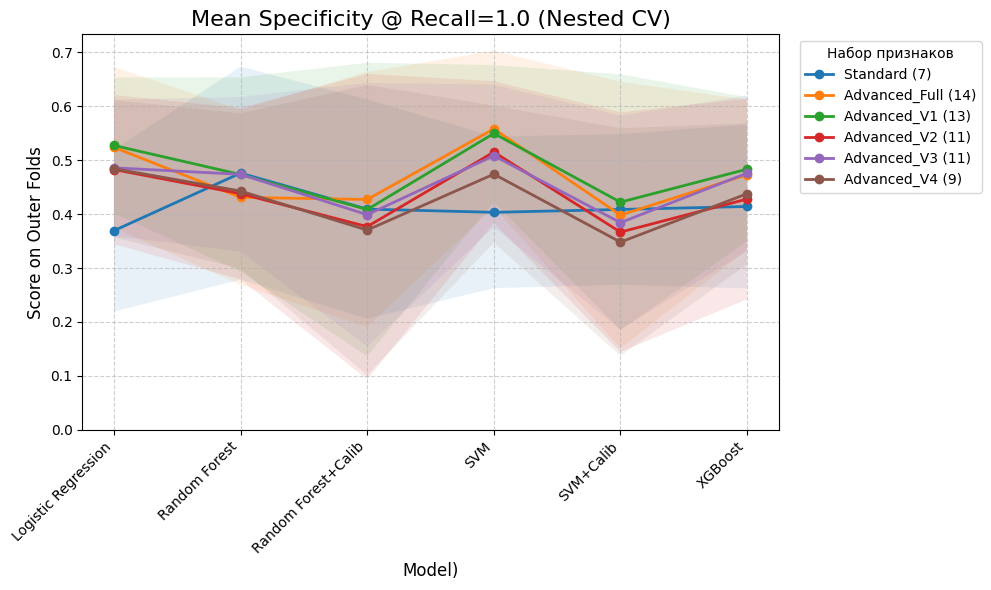

In [10]:
results_df_ncv = pd.DataFrame(all_nested_cv_results)

# Таблица для Mean CV scores
pivot_mean = results_df_ncv.pivot_table(
    values="mean_cv_score",
    index="feature_set",
    columns="model_display"
)
# Таблица для Std CV scores
pivot_std = results_df_ncv.pivot_table(
    values="std_cv_score",
    index="feature_set",
    columns="model_display"
)

pivot_mean = pivot_mean.reindex(FEATURE_SETS.keys())
pivot_std = pivot_std.reindex(FEATURE_SETS.keys())

display(pivot_mean)
display(pivot_std)

# --- Визуализация CV-оценок ---
plot_cv_scores(pivot_mean, pivot_std)

In [11]:
print("\n===== Сводка лучших моделей (по результатам Nested CV на обучающей выборке) =====")
display(results_df_ncv[[
    'feature_set',
    'model_display',
    'mean_cv_score',
    'std_cv_score',
    'best_params_on_full_train'
]].sort_values(by="mean_cv_score", ascending=False))


===== Сводка лучших моделей (по результатам Nested CV на обучающей выборке) =====


,feature_set,model_display,mean_cv_score,std_cv_score,best_params_on_full_train
8,Advanced_Full (14),SVM,0.5580,0.1449,"{'model__C': 0.01, 'model__class_weight': 'bal..."
14,Advanced_V1 (13),SVM,0.5496,0.1268,"{'model__C': 0.01, 'model__class_weight': 'bal..."
12,Advanced_V1 (13),Logistic Regression,0.5274,0.1260,"{'model__C': 0.01, 'model__class_weight': 'bal..."
6,Advanced_Full (14),Logistic Regression,0.5238,0.1490,"{'model__C': 0.01, 'model__class_weight': 'bal..."
20,Advanced_V2 (11),SVM,0.5151,0.1312,"{'model__C': 0.01, 'model__class_weight': 'bal..."
26,Advanced_V3 (11),SVM,0.5081,0.1318,"{'model__C': 0.01, 'model__class_weight': 'bal..."
24,Advanced_V3 (11),Logistic Regression,0.4859,0.1261,"{'model__C': 0.01, 'model__class_weight': 'bal..."
30,Advanced_V4 (9),Logistic Regression,0.4843,0.1271,"{'model__C': 0.01, 'model__class_weight': 'bal..."
17,Advanced_V1 (13),XGBoost,0.4834,0.1334,"{'model__max_depth': 3, 'model__n_estimators':..."
18,Advanced_V2 (11),Logistic Regression,0.4826,0.1382,"{'model__C': 0.01, 'model__class_weight': 'bal..."


### Тестирование и сравнение моделей на Test

In [12]:
test_metrics = []

for item in all_nested_cv_results:
    estimator = item['best_estimator_trained_on_full_train']

    # Определяем порог на полном обучающем наборе
    y_train_proba = estimator.predict_proba(X_train)
    threshold = find_best_threshold_for_full_recall(y_train, y_train_proba, pos_label=1)

    # Применяем модель и порог к тестовому набору
    y_test_proba = estimator.predict_proba(X_test)
    y_test_pred = np.where(get_class_proba(y_test_proba, pos_label=1) >= threshold, 1, 0)

    # Вычисляем метрики
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred, labels=[0, 1]).ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall_tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0 # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0 # False Positive Rate

    test_metrics.append({
        "feature_set": item['feature_set'],
        "model_display": item['model_display'],
        "Threshold": threshold,
        "Precision": precision,
        "Recall (TPR)": recall_tpr,
        "FPR": fpr
    })

test_results_df = pd.DataFrame(test_metrics)

pivot_test = test_results_df.pivot_table(
    index='feature_set',
    columns='model_display',
    values=['FPR', 'Precision', 'Recall (TPR)', 'Threshold']
)
display(pivot_test)

FPR                                    \
model_display      Logistic Regression Random Forest Random Forest+Calib   
feature_set                                                                
Advanced_Full (14)              0.6250        0.2917              0.3542   
Advanced_V1 (13)                0.5833        0.2500              0.2708   
Advanced_V2 (11)                0.6042        0.2917              0.4375   
Advanced_V3 (11)                0.6042        0.2917              0.3750   
Advanced_V4 (9)                 0.6458        0.3125              0.3125   
Standard (7)                    0.6250        0.3125              0.2500   

                                                      Precision                \
model_display         SVM SVM+Calib XGBoost Logistic Regression Random Forest   
feature_set                                                                     
Advanced_Full (14) 0.6458    0.6042  0.0000              0.2683        0.3333   
Advanced_V1 (13)   0.5625    0.5417  0.0000              0.2821        0.4000   
Advanced_V2 (11)   0.5625    0.5208  0.0000              0.2750        0.4167   
Advanced_V3 (11)   0.5625    0.5417  0.0000              0.2750        0.3636   
Advanced_V4 (9)    0.6042    0.6458  0.0208              0.2791        0.4231   
Standard (7)       0.5417    0.5417  0.0208              0.2857        0.4231   

                                               ...        Recall (TPR)         \
model_display      Random Forest+Calib    SVM  ... Random Forest+Calib    SVM   
feature_set                                    ...                              
Advanced_Full (14)              0.3704 0.2619  ...              0.8333 0.9167   
Advanced_V1 (13)                0.4091 0.2895  ...              0.7500 0.9167   
Advanced_V2 (11)                0.3438 0.2895  ...              0.9167 0.9167   
Advanced_V3 (11)                0.3333 0.2895  ...              0.7500 0.9167   
Advanced_V4 (9)                 0.4231 0.2927  ...              0.9167 1.0000   
Standard (7)                    0.4783 0.2973  ...              0.9167 0.9167   

                                               Threshold                \
model_display      SVM+Calib XGBoost Logistic Regression Random Forest   
feature_set                                                              
Advanced_Full (14)    0.9167  0.1667              0.3651        0.3596   
Advanced_V1 (13)      0.9167  0.1667              0.3855        0.3652   
Advanced_V2 (11)      0.9167  0.0000              0.3913        0.3052   
Advanced_V3 (11)      0.9167  0.0833              0.3905        0.3007   
Advanced_V4 (9)       1.0000  0.0833              0.3749        0.2732   
Standard (7)          0.9167  0.3333              0.4449        0.3548   

                                                                 
model_display      Random Forest+Calib    SVM SVM+Calib XGBoost  
feature_set                                                      
Advanced_Full (14)              0.1221 0.0453    0.0556  0.9595  
Advanced_V1 (13)                0.1364 0.0517    0.0632  0.9595  
Advanced_V2 (11)                0.0833 0.0478    0.0547  0.9399  
Advanced_V3 (11)                0.1189 0.0476    0.0571  0.9374  
Advanced_V4 (9)                 0.1228 0.0403    0.0222  0.9348  
Standard (7)                    0.1614 0.1177    0.0833  0.9404  

[6 rows x 24 columns]

### Анализ лучшей модели


--- Детальный анализ лучшей модели ---
	• Модель:          'SVM'
	• Набор признаков: 'Advanced_Full (14)'
	• Лучший CV-скор (Specificity@R=1.0): 0.5580 ± 0.1449

Финальная модель (лучшая из лучших):
	• Гиперпараметры:    {'model__C': 0.01, 'model__class_weight': 'balanced', 'model__gamma': 'scale', 'model__kernel': 'linear'}
	• Рабочий порог:     0.0453

--- Отчет по классификации на ТЕСТЕ (Порог ≈ 0.045) ---
              precision    recall  f1-score   support

 Healthy (0)       0.94      0.35      0.52        48
 Anomaly (1)       0.26      0.92      0.41        12

    accuracy                           0.47        60
   macro avg       0.60      0.64      0.46        60
weighted avg       0.81      0.47      0.49        60


Ключевые метрики скрининга на тесте:
	• Ложные тревоги (FP): 31
	• Пропущенные аномалии (FN): 1
	• Accuracy:            0.4667
	• Recall (аномалии):   0.9167


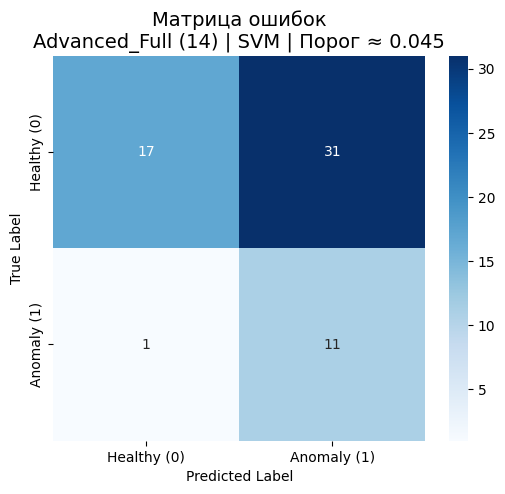

In [13]:
best_model_info = results_df_ncv.loc[results_df_ncv['mean_cv_score'].idxmax()]

final_fs_name = best_model_info['feature_set']
final_model_name_display = best_model_info['model_display']
best_final_estimator = best_model_info['best_estimator_trained_on_full_train']
best_params = best_model_info['best_params_on_full_train']
best_cv_score = best_model_info['mean_cv_score']
best_cv_std = best_model_info['std_cv_score']

print(f"\n--- Детальный анализ лучшей модели ---")
print(f"\t• Модель:          '{final_model_name_display}'")
print(f"\t• Набор признаков: '{final_fs_name}'")
print(f"\t• Лучший CV-скор (Specificity@R=1.0): {best_cv_score:.4f} ± {best_cv_std:.4f}")

y_train_proba = best_final_estimator.predict_proba(X_train)
final_threshold = find_best_threshold_for_full_recall(y_train, y_train_proba, pos_label=1)

print("\nФинальная модель (лучшая из лучших):")
print(f"\t• Гиперпараметры:    {best_params}")
print(f"\t• Рабочий порог:     {final_threshold:.4f}")

# Оценка на тесте
y_test_proba = best_final_estimator.predict_proba(X_test)
y_probs = get_class_proba(y_test_proba, pos_label=1)
y_pred_final = np.where(y_probs >= final_threshold, 1, 0)

print(f"\n--- Отчет по классификации на ТЕСТЕ (Порог ≈ {final_threshold:.3f}) ---")
print(classification_report(y_test, y_pred_final, labels=[0, 1], target_names=['Healthy (0)', 'Anomaly (1)']))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final, labels=[0, 1]).ravel()
print("\nКлючевые метрики скрининга на тесте:")
print(f"\t• Ложные тревоги (FP): {fp}")
print(f"\t• Пропущенные аномалии (FN): {fn}")
print(f"\t• Accuracy:            {(tp+tn)/(tp+tn+fp+fn):.4f}")
print(f"\t• Recall (аномалии):   {tp/(tp+fn) if (tp+fn) > 0 else 0:.4f}")

plot_confusion_matrix(
    y_test, y_pred_final,
    f'Матрица ошибок\n{final_fs_name} | {final_model_name_display} | Порог ≈ {final_threshold:.3f}'
)

In [14]:
import pickle
import datetime
import os
from pathlib import Path

class ModelSerializer:
    """Класс для сериализации и десериализации моделей с метаданными"""

    def __init__(self, base_path='models'):
        self.base_path = Path(base_path)
        self.base_path.mkdir(exist_ok=True)

    def save_model(self, pipeline, model_name, **metadata):
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{model_name}_{timestamp}.pkl"
        filepath = self.base_path / filename

        base_metadata = {
            'model_name': model_name,
            'filename': filename,
            'saved_date': datetime.datetime.now().isoformat(),
            'file_size': None
        }
        base_metadata.update(metadata)

        model_package = {
            'pipeline': pipeline,
            'metadata': base_metadata
        }

        try:
            with open(filepath, 'wb') as f:
                pickle.dump(model_package, f)

            file_size = os.path.getsize(filepath)
            base_metadata['file_size'] = f"{file_size / 1024:.2f} KB"

            with open(filepath, 'wb') as f:
                pickle.dump(model_package, f)

            print(f"Модель сохранена: {filepath}")
            return filepath

        except Exception as e:
            print(f"Ошибка сохранения: {e}")
            return None

    def load_latest_model(self, model_name):
        """Загружает последнюю версию модели по имени"""
        pattern = f"{model_name}_*.pkl"
        model_files = list(self.base_path.glob(pattern))

        if not model_files:
            raise FileNotFoundError(f"Модели {model_name} не найдены")

        latest_file = sorted(model_files)[-1]

        return self.load_model(latest_file)

    def load_model(self, filepath):
        """Загружает конкретную модель"""

        if isinstance(filepath, str):
            filepath = Path(filepath)

        if not filepath.exists():
            raise FileNotFoundError(f"Файл {filepath} не найден")

        try:
            with open(filepath, 'rb') as f:
                model_package = pickle.load(f)

            print(f"Загружена модель: {model_package['metadata'].get('model_name', 'Unknown')}")
            return model_package

        except Exception as e:
            print(f"Ошибка загрузки: {e}")
            raise

In [15]:
serializer = ModelSerializer('../models')

final_fs_name = best_model_info['feature_set']
best_final_estimator = best_model_info['best_estimator_trained_on_full_train']
best_params = best_model_info['best_params_on_full_train']


serializer.save_model(
    pipeline=best_final_estimator,
    model_name=final_model_name_display,
    model_version='0.1.0',
    feature_set=final_fs_name,
    threshold=final_threshold,
    performance_metrics={'Specificity@Reacall=1': best_cv_score, 'std': best_cv_std},
    params=str(best_params),
)
del serializer

Модель сохранена: ../models/SVM_20250923_125615.pkl


In [16]:
serializer = ModelSerializer('../models')
loaded_package = serializer.load_latest_model(final_model_name_display)
model = loaded_package['pipeline']
threshold = loaded_package['metadata']["threshold"] or 0.5 # TODO: d.get(index, default)
print(loaded_package['metadata'])
y_test_proba = model.predict_proba(X_test)
y_probs = get_class_proba(y_test_proba, pos_label=1)
y_pred_final = np.where(y_probs >= threshold, 1, 0)

print(classification_report(y_test, y_pred_final, labels=[0, 1], target_names=['Healthy (0)', 'Anomaly (1)']))

Загружена модель: SVM
{'model_name': 'SVM', 'filename': 'SVM_20250923_125615.pkl', 'saved_date': '2025-09-23T12:56:15.558200', 'file_size': '22.68 KB', 'model_version': '0.1.0', 'feature_set': 'Advanced_Full (14)', 'threshold': np.float64(0.04532518637296819), 'performance_metrics': {'Specificity@Reacall=1': np.float64(0.5579847053531264), 'std': np.float64(0.14487175122148602)}, 'params': "{'model__C': 0.01, 'model__class_weight': 'balanced', 'model__gamma': 'scale', 'model__kernel': 'linear'}"}
              precision    recall  f1-score   support

 Healthy (0)       0.94      0.35      0.52        48
 Anomaly (1)       0.26      0.92      0.41        12

    accuracy                           0.47        60
   macro avg       0.60      0.64      0.46        60
weighted avg       0.81      0.47      0.49        60

